### 檢查tensorflow 環境

In [150]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8481087133485729600
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7803502592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7099697130533302915
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

### 0. import

In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np

from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm.notebook import tqdm
tqdm().pandas()

0it [00:00, ?it/s]

## Data processing

### 1. 做 data cleaning

In [2]:
# Loading a text file into memory
# 讀檔案
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
# get all imgs with their captions
# 建立一個字典，儲存一張圖片對應五個句子
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions = {}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [caption]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

In [5]:
import pandas as pd
des = all_img_captions('Flickr8k_text/Flickr8k.token.txt')
df = pd.DataFrame(des).T
#df.head()

In [6]:
## Data cleaning- lower casing, removing puntuations and words containing numbers
## 清理文字data，轉換成全部小寫、去除標點符號、
def cleaning_text(captions):
    ## captions = all_img_captions(filename)，type()=字典
    
    # 在 string.punctuation 裡面有的都會被視為 None
    # string.punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    table = str.maketrans('','',string.punctuation)
    
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string

            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [7]:
cltxt = cleaning_text(des)
df = pd.DataFrame(cltxt).T
#df.head()

In [8]:
# 建立一個集合，把所有字分開來
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()

    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    
    return vocab

In [9]:
#text_vocabulary(des)

In [10]:
# All descriptions in one file 

# discription.txt:
#    1000268201_693b08cb0e.jpg	child in pink dress is climbing up set of stairs in an entry way
#    1000268201_693b08cb0e.jpg	girl going into wooden building
#    1000268201_693b08cb0e.jpg	little girl climbing into wooden playhouse
#    1000268201_693b08cb0e.jpg	little girl climbing the stairs to her playhouse
#    1000268201_693b08cb0e.jpg	little girl in pink dress going into wooden cabin

def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [11]:
# all_train_captions = []
# for key, val in descriptions.items():
#     for cap in val:
#         all_train_captions.append(cap)

# # Consider only words which occur at least 8 times in the corpus
# word_count_threshold = 8
# word_counts = {}
# nsents = 0
# for sent in all_train_captions:
#     nsents += 1
#     for w in sent.split(' '):
#         word_counts[w] = word_counts.get(w, 0) + 1

# vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]

# print('preprocessed words %d ' % len(vocab))


In [12]:
#dataset_text = "D:\dataflair projects\Project - Image Caption Generator\Flickr_8k_text"
#dataset_images = "D:\dataflair projects\Project - Image Caption Generator\Flicker8k_Dataset"
dataset_text = "Flickr8k_text"
dataset_images = "Flicker8k_Dataset"

In [13]:
# we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
# loading the file that contains all data
# mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

# cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

# building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

# saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


### 2. Extracting the feature vector from all images
- 使用 Xception model，該model已在具有 1000 個不同類別的 imagenet datasets 上進行了分類
- Xception model 以 $299\times299\times3$ 的size作為input。去掉最後一個分類層，得到 2048 個 feature vector。

In [14]:
def extract_features(directory):
    model = Xception( include_top=False, pooling='avg' )
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0

        feature = model.predict(image)
        features[img] = feature
    return features

In [33]:
#2048 feature vector
dataset_images = "Flicker8k_Dataset"
features = extract_features(dataset_images)
dump(features, open("features02.p","wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

#### 看一下詳細的處理過程：

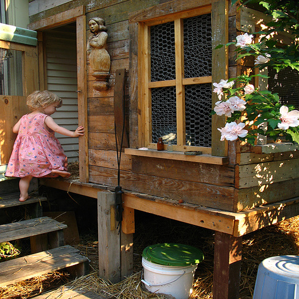

In [21]:
image = Image.open('Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
image = image.resize((299,299))
image

In [22]:
image = np.expand_dims(image, axis=0)
image = image/127.5 - 1
image

array([[[[-0.45882353, -0.44313725, -0.31764706],
         [-0.11372549,  0.01960784, -0.02745098],
         [-0.10588235,  0.01176471,  0.01960784],
         ...,
         [-0.96862745, -0.97647059, -0.97647059],
         [-0.94509804, -0.9372549 , -0.96078431],
         [-0.96078431, -0.94509804, -0.96862745]],

        [[-0.49019608, -0.4745098 , -0.37254902],
         [-0.10588235,  0.01960784, -0.04313725],
         [-0.09803922,  0.03529412,  0.05882353],
         ...,
         [-0.95294118, -0.96078431, -0.96862745],
         [-0.9372549 , -0.92156863, -0.94509804],
         [-0.95294118, -0.92156863, -0.95294118]],

        [[-0.50588235, -0.50588235, -0.38039216],
         [-0.09019608,  0.02745098, -0.00392157],
         [-0.09803922,  0.02745098,  0.09803922],
         ...,
         [-0.94509804, -0.92941176, -0.94509804],
         [-0.95294118, -0.8745098 , -0.97647059],
         [-0.83529412, -0.70196078, -0.9372549 ]],

        ...,

        [[ 0.36470588, -0.33333333, -0

In [110]:
model = Xception( include_top=False, pooling='avg' )
yp = model.predict(image)
yp, yp.shape

(array([[0.47331595, 0.01729779, 0.07342803, ..., 0.08566103, 0.02101761,
         0.23772213]], dtype=float32),
 (1, 2048))

### 3. 載入data

In [32]:
features = load(open("features.p","rb"))

In [33]:
# load the data 
def load_photos(filename):
    # filename = 'Flickr_8k.trainImages.txt'
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [34]:
# load_photos('Flickr8k_text/Flickr_8k.trainImages.txt')
photos = load_photos(filename)

In [35]:
def load_clean_descriptions(filename, photos):
    # filename = 'descriptions.txt'
    # photos = load_photos('Flickr_8k.trainImages.txt')
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        
        words = line.split()
        if len(words)<1 :
            continue
    
        image, image_caption = words[0], words[1:]
        
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

In [39]:
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [136]:
# 圖片訓練資料檔案名稱
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"

#train = loading_data(filename)
train_imgs = load_photos(filename)

train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)

#train_descriptions

train_descriptions:

    '1000268201_693b08cb0e.jpg': ['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
                                  '<start> girl going into wooden building <end>',
                                  '<start> little girl climbing into wooden playhouse <end>',
                                  '<start> little girl climbing the stairs to her playhouse <end>',
                                  '<start> little girl in pink dress going into wooden cabin <end>'],
    '1001773457_577c3a7d70.jpg': ['<start> black dog and spotted dog are fighting <end>',
                                  '<start> black dog and tricolored dog playing with each other on the road <end>',
                                  '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
                                  '<start> two dogs of different breeds looking at each other on the road <end>',
                                  '<start> two dogs on pavement moving toward each other <end>'],
    '1002674143_1b742ab4b8.jpg': ['<start> little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
                                  '<start> little girl is sitting in front of large painted rainbow <end>',
                                  '<start> small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>',
                                  '<start> there is girl with pigtails sitting in front of rainbow painting <end>',
                                  '<start> young girl with pigtails painting outside in the grass <end>'],
    '1003163366_44323f5815.jpg': ['<start> man lays on bench while his dog sits by him <end>',
                                  '<start> man lays on the bench to which white dog is also tied <end>',
                                  '<start> man sleeping on bench outside with white and black dog sitting next to him <end>',
                                  '<start> shirtless man lies on park bench with his dog <end>',
                                  '<start> man laying on bench holding leash of dog sitting on ground <end>'],
                                  ......

In [111]:
train_features = load_features(train_imgs)

#train_features

### 4. Tokenize
- 電腦不懂英文單字，需要用數字來表示。因此將為詞彙表的每個單字對應到一個唯一的 index
- Keras 的 tokenizer 函數，從詞彙表中創建標記並保存到“tokenizer.p”pickle 文件中。

In [49]:
# converting dictionary to clean list of descriptions
# 把descriptions的key轉為list
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [3]:
# dict_to_list(descriptions)

In [51]:
# creating tokenizer class 
# this will vectorise text corpus
# each integer will represent token in dictionary 

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [62]:
# give each word a index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
# dir(tokenizer)

In [4]:
# tokenizer.word_index

In [64]:
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
# 單字數目
vocab_size 

7577

計算descriptions的最大長度，對於確定模型結構參數很重要。

In [65]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [66]:
features['1000268201_693b08cb0e.jpg'][0]

array([0.36452794, 0.12713662, 0.0013574 , ..., 0.221817  , 0.01178991,
       0.24176797], dtype=float32)

### 5. Create Data generator
舉例：input 是 [x1, x2]，output 是 y，其中 x1 是該圖像的 2048 個feature vector，x2 是text sequence，y 是 model 預測的 text sequence。

| $x_1$ (feature vector) | $x_2$ (Text sequence)             |$y$ (word to predict)|               
|:--------------------:|:------------------------------:|:-----------------:|               
| feature	           | start                          | two               |
| feature	           | start, two                     | dogs              | 
| feature	           | start, two, dogs               | drink             |  
| feature	           | start, two, dogs, drink        | water             |  
| feature	           | start, two, dogs, drink, water | end               |

In [72]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [71]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]         

In [118]:
for key, description_list in descriptions.items():
    test = description_list[0]
    break
#test
#tokenizer.texts_to_sequences([test])[0]
len(tokenizer.texts_to_sequences([test])[0])

14

In [73]:
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

## Defining the CNN-RNN model

1. Photo feature extractor：從圖像中提取的特徵大小為 2048，使用密集層，我們將維度減少到 256 個節點。we extracted features from pretrained model Xception. 
2. Sequence processor：嵌入層將處理文本輸入，然後是 LSTM 層。word embedding layer that handles text, followed by LSTM 
3. Decoder：合併上述兩層的輸出，我們將通過密集層進行處理以進行最終預測。最後一層將包含與我們的詞彙量相等的節點數。Both 1 and 2 model produce fixed length vector. They are merged together and processed by dense layer to make final prediction

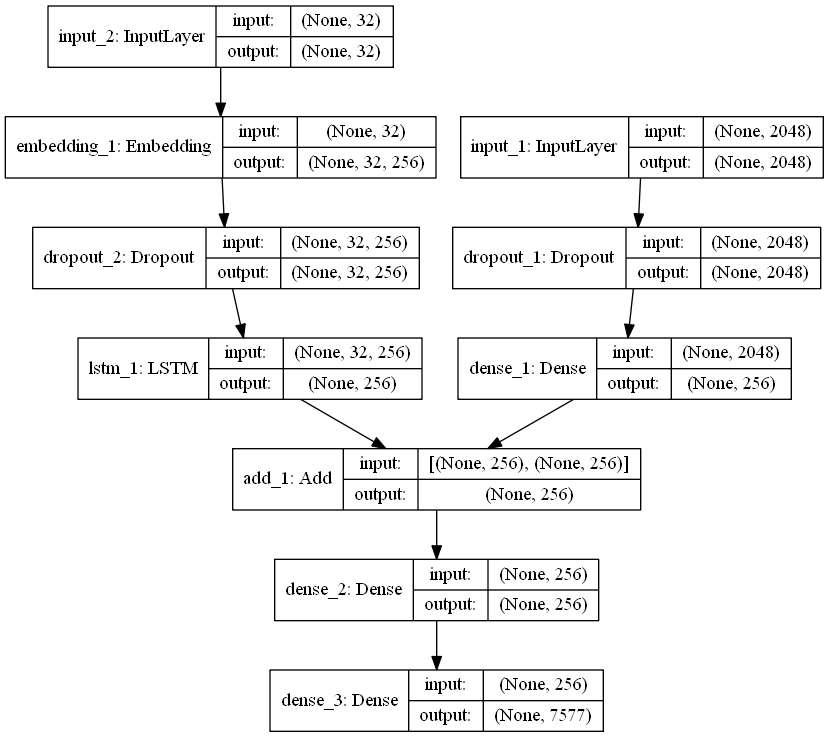

In [22]:
from tensorflow.keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    
    # CNN model 將圖片 features 從 2048 轉換為 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [24]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models02")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models02/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 32, 256)      1939712     ['input_4[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_3[0][0]']  

C:\Users\User\AppData\Local\Temp/ipykernel_2884/1241100705.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


6000/6000 [==============================] - 446s 74ms/step - loss: 4.5114


C:\Users\User\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


6000/6000 [==============================] - 433s 72ms/step - loss: 2.8009


In [ ]:
!pip install pydot

In [114]:
import sys
sys.executable

'C:\\Users\\User\\anaconda3\\envs\\tf_gpu02\\python.exe'

In [38]:
import tensorflow

In [39]:
tensorflow.__version__

'2.7.0'

## Testing

In [129]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [130]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [131]:
def extract_features_test(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

In [140]:
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'
filename = "Flickr8k_text/Flickr_8k.testImages.txt"
test_images_file = load_photos(filename)
np.random.seed(20)
ind = np.random.randint(0,1000,10)
print(ind)
test_images = []
for i in range(1000):
    if i in ind:
        test_images.append(test_images_file[i])
test_images

[355 474 271 223 924 218 393 404 843 790]


['3048597471_5697538daf.jpg',
 '2497420371_74788d7ba1.jpg',
 '3116769029_f5a76f04ba.jpg',
 '2968182121_b3b491df85.jpg',
 '3592968286_b63c81bcd2.jpg',
 '2482629385_f370b290d1.jpg',
 '3047264346_e24601bfbf.jpg',
 '3571147934_d1c8af1d6e.jpg',
 '113678030_87a6a6e42e.jpg',
 '197504190_fd1fc3d4b7.jpg']

In [ ]:
test_descriptions = load_clean_descriptions("descriptions.txt", test_images)
test_descriptions




predict:  start brown dog is running through the grass end
answer: 
['<start> brown dog is swimming through water with an orange ball in its mouth <end>'
 '<start> dark brow dog holds an orange ball in his mouth while walking through water <end>'
 '<start> dog wading in the water with ball in his mouth <end>'
 '<start> wet brownishred dog with an orange ball in his mouth is swimming in some water <end>'
 '<start> brown dog in water with orange and blue ball in mouth <end>']


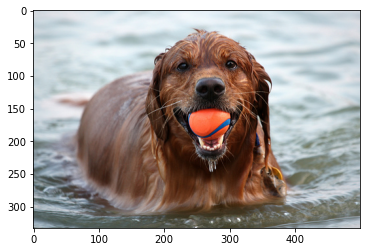




predict:  start man in red shirt is sitting on bench end
answer: 
['<start> man fiddles with shopping bag outside near shopping cart <end>'
 '<start> man gathers his belongings by the side of building <end>'
 '<start> man in black cap is opening bag beside bicycle and shopping cart <end>'
 '<start> man looks in bag near some grocery carts and bike <end>'
 '<start> man outside at red brick building with grocery cart bike and miscellaneous <end>']


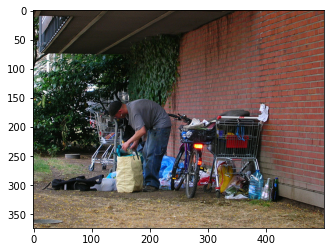




predict:  start woman in pink shirt is sitting on the sidewalk end
answer: 
['<start> boy in tan coat throws some red leaves at the camera <end>'
 '<start> boy throws red and orange leaves into the air <end>'
 '<start> little boy is playing with the autumn leaves <end>'
 '<start> little boy with green shirt and brown jacket is throwing orange fall leaves <end>'
 '<start> young boy tosses autumn leaves <end>']


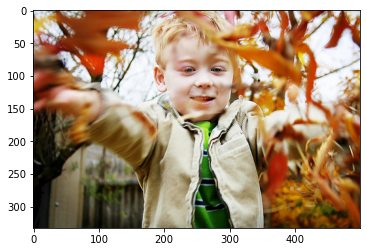




predict:  start two dogs are running through the grass end
answer: 
['<start> brown number six race dog is slightly behind black race dog on track <end>'
 '<start> two dogs race across the track <end>'
 '<start> two greyhounds race <end>'
 '<start> two muzzled greyhound dogs running around track <end>'
 '<start> two muzzled racing dogs running along track <end>']


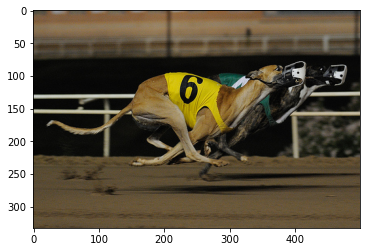




predict:  start man in red shirt is sitting on bench end
answer: 
['<start> man in fancy clothing plays guitar on stage <end>'
 '<start> man playing guitar under the lights with other people in the background <end>'
 '<start> woman plays guitar by round light <end>'
 '<start> man playing guitar in dark room <end>'
 '<start> the man played guitar in the band <end>']


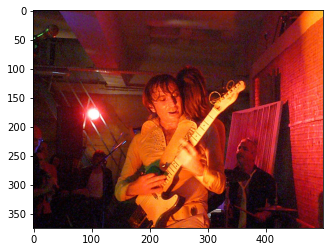




predict:  start dog is running through the grass end
answer: 
['<start> brown dog wading into marshy pond <end>'
 '<start> dog on the edge of body of water <end>'
 '<start> dog walking into lake with reeds in the background <end>'
 '<start> dog wearing blue leash walks into body of water <end>'
 '<start> large brown dog leans into the water from the grassy shore <end>']


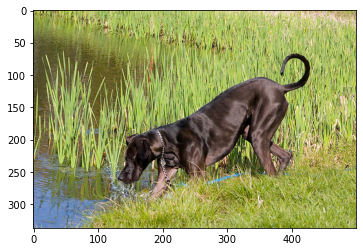




predict:  start man in black shirt is standing next to woman in black shirt with his hand crossed end
answer: 
['<start> girl and guy dressed up in costumes <end>'
 '<start> man dressed as teen wolf hugs woman made up like vampire <end>'
 '<start> man in werewolf mask is with woman wearing elf ears <end>'
 '<start> the man wearing the mask and sunglasses has his arm around the woman who is wearing fake pointed ears <end>'
 '<start> two individuals dressed up like animals are posing for the camera <end>']


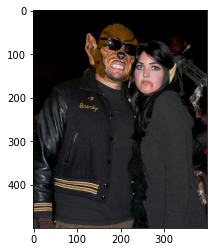




predict:  start man in black shirt is standing in front of crowd end
answer: 
['<start> girl in black coat next to some school kids <end>'
 '<start> four teenagers are standing at the foot of some steps by brick wall <end>'
 '<start> kids are waiting at the bottom of staircase attached to brick building <end>'
 '<start> peoople stand outside building near street <end>'
 '<start> teenagers congregate outside brick building <end>']


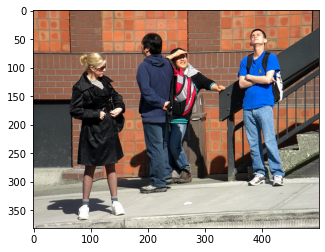




predict:  start skier is riding down snowy mountain end
answer: 
['<start> snowboarder sits on slope with skiers and boarders nearby <end>'
 '<start> snowboarder takes rest on the mountainside <end>'
 '<start> snowboarders sitting in the snow while skiers take the hill <end>'
 '<start> the snowboarder is sitting down <end>'
 '<start> two skiers stand two sit on slopes <end>']


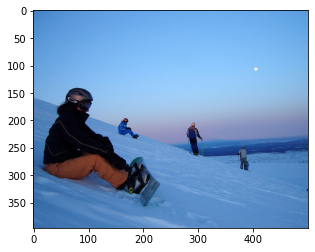




predict:  start two boys play soccer on the grass end
answer: 
['<start> two boys in field kicking soccer ball <end>'
 '<start> two children are playing with soccer ball on grass <end>'
 '<start> two children playing with ball on the grass <end>'
 '<start> two children play soccer in the park <end>'
 '<start> two little boys are playing outside with their soccer ball on the green grass <end>']


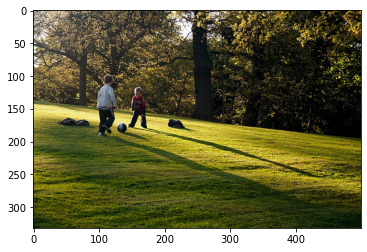

In [149]:
import matplotlib.pyplot as plt
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

for path in test_images:
#img_path = "Flicker8k_Dataset/2903617548_d3e38d7f88.jpg"
    img_path = "Flicker8k_Dataset/"+path
    photo = extract_features_test(img_path, xception_model)
    img = Image.open(img_path)

    description = generate_desc(model, tokenizer, photo, max_length)
    print("\n\n")
    print("predict: ", description)
    print('answer: ')
    print(np.array(test_descriptions[path]))
    plt.imshow(img)
    plt.show()